---
### **NOTA:** Toda la información producida durante el proyecto esta disponible en **https://drive.google.com/drive/folders/1v6ttK1kLlbDPv3gwIl_qY6QtO9HhZjMk?usp=sharing** el drive de Google: las bases de datos con los tweets descargados y procesados se encuentran como **archivos CSV** zipeados, asi como tambien los modelos de NLP (serializados con pickle).
---
# **TA_POLITICA-03_preprocessing.ipynb**
>## ENTRADA:
>## **"politicosdb.csv"** :  ( drive: **politicos_lista_anotada.zip** )
>## Informacion sobre cada usuario con información anotada ( **partido** y **orientacion** ) usada para reparticionar los tweets en DataFrames organizados por orientacion y partido
>## **"tweetsdb_@nombre_usario.csv"** :  ( drive: **tweets_politicos_db.zip** ) 
>## todos los tweets recuperados de cada @nombre_usuario 
---
>## SALIDA:
>## **"tweets-partido-db_xxx.csv"** ( drive: **tweets_por_partidos_db.zip** ) Todos los tweets agregados por partido (un archivo para todos los tweets del partido xxx)
>### **xxx** puede ser 
mor - partido morado / ap - accion popular / fp - fuerza popular /
ppk - peruanos por el kambio / per - periodista / fa - frente amplio / nul - sin afiliacion / pnp - partido de Ollanta Humala / mil - militar / apra - APRA / pp - podemos Perú / upp - unión por el peru / PPP - Perú posible / ppc - partido popular cristiano / app - alianza para el progreso / psn - partido solidaridad nacional / np - nuevo peru
>## **"tweets-orientacion-db_yyy.csv"** ( drive: **tweets_por_orientacion_db.zip** )
>### **yyy** puede ser 
der - derecha / cder - centro derecha / cen - centro / cizq - centro izquierda / izq - izquierda

In [6]:
from platform import python_version
print(python_version())

3.7.7


In [7]:
import pandas as pd
import re
import sys
import time
import random
import pickle
from datetime import datetime,timedelta, date
import string
sys.version

'3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]'

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# NLTK
import nltk
from nltk.corpus import stopwords
nltk.download( 'stopwords' )

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Facundo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## CARGAMOS LA BD (DataFrame) CON LA LISTA DE POLITICOS

In [9]:
db_politicos_csv = "politicosdb.csv"
politicosdb_df = pd.read_csv(db_politicos_csv )

### Una muestra de ese DataFrame

In [30]:
politicosdb_df.sample(5)

,id,screen_name,nombre,partido,nombre_partido,orientacion,total_tweets,tweets,fecha_creado,fecha_min,descripcion,num_seguidores
5,15043710,@IndiraHuilca,Indira Huilca,np,nuevo peru,izq,10634,6466,2008-06-08,2008-03-07,Feminista y socialista. Socióloga por la UNMSM...,126073
68,54091900,@evelinorcon,Evelin Orcón,apra,apra,der,8882,5168,2009-07-06,2009-06-21,"Sub Secretaria General del APRA, he sido regid...",5861
30,1192891723,@geluseg,German Luna Segura,apra,apra,der,2022,2022,2013-02-18,2013-02-18,Analista y escritor.,446
1,1017875140313518081,@EnriqueFCHA,Enrique Fernández Chacón,fa,frente amplio,izq,5233,3148,2018-07-13,2018-07-09,Político de toda la vida 🇵🇪\n#CuarentenaSinHam...,20145
81,86457557,@Valderrama_En,Enrique Valderrama,apra,apra,der,11582,4754,2009-10-31,2009-05-12,Director de Punto de Encuentro. Columnista de ...,6656


## POR CADA POLITICO CARGAMOS SU RESPECTIVO DataFrame CON TODOS LOS TWEETS RECUPERADOS

In [11]:
def cargaTweetsDB(df_users):
    userstweets_dict = {}
    for idx,scr_name in enumerate(df_users['screen_name']):   
        usuario_df = pd.read_csv("tweetsdb_"+scr_name+".csv" )
        usuario_df.fillna('', inplace=True)
        userstweets_dict[scr_name[1:]]=usuario_df.copy()        
    return userstweets_dict
    
politicosdf_dict=cargaTweetsDB(politicosdb_df)

politicodf_list = []
for politico in politicosdf_dict.keys():
    politicodf_list.append(politicosdf_dict[politico])


### Una muestra de el DataFrame de un polítco

In [12]:
politicodf_list[6].sample(10)

,id,User,Text,Date,Retweets,Mentions,HashTags,text_prep
4018,912371787958296576,MarisaGlave,Lo hacen turistas peruanos en otros paises. Va...,2017-09-25,1,,,hacen turistas peruanos paises vargas llosa pa...
8084,307315108072259584,MarisaGlave,".@SusanaVillaran ""trabajamos d la mano con el ...",2013-03-01,4,@susanavillaran,,trabajamos mano alcalde vecinos romper discrec...
5349,714853408264560641,MarisaGlave,Debate completo con Yeni Vilcatoma No a la Gue...,2016-03-29,18,,,debate completo yeni vilcatoma guerra sucia va...
8846,218498168348884994,MarisaGlave,@maralegre @SusanaVillaran seremos firmes. Nue...,2012-06-29,2,@maralegre @susanavillaran,,firmes compromiso comunidad lgtb ratificamos
1945,1168516929281286144,MarisaGlave,"RT @sigridbazan: #ParemosElAcoso Basta ya , no...",2019-9-2,43,@sigridbazan,#ParemosElAcoso,basta podemos seguir normalizando acoso hora s...
2866,1113118413159915520,MarisaGlave,Ayer en el lanzamiento de la campaña ciudadana...,2019-4-2,17,,#ElAguaEsTuVida #YoDefiendoElAgua,ayer lanzamiento campaña ciudadana participand...
7731,344814032039055360,MarisaGlave,Denuncia de @Frospigliosi debe ser tomada en s...,2013-06-12,7,@Frospigliosi,,denuncia debe tomada serio grave democracia us...
513,1254886979713540096,MarisaGlave,RT @FlorPabloMedina: El año 2015 se inició la ...,2020-4-27,61,@FlorPabloMedina,,2015 inicio ruta recuperacion educacion public...
3010,1103456875344003077,MarisaGlave,Mañana es el #PlenoMujer y junto a @TaniaPario...,2019-3-7,62,@TaniaPariona @IndiraHuilca,#PlenoMujer #LeyDelApellido #AcosoPolítico #Ap...,mañana junto trabajado iniciativas favor mujer...
8343,286706363516727296,MarisaGlave,@karlachaman @zoile gracias!! Esa es la idea!,2013-01-03,0,@karlachaman @zoile,,gracias idea


## PREPROCESAMIENTO DE TWEETS EN EL SIGUIENTE ORDEN
1. REMOVEMOS LINKS
2. REMOVEMOS MENCIONES
3. REMOVEMOS HASHTAGS
4. REMOVEMOS SIGNOS DE PUNTUACION
5. REMOVEMOS PALABRAS CORTAS (len <= 3)
6. REMOVEMOS SIGNOS DIACRÍTICOS
7. REMOVEMOS PALABRAS QUE NO SEAN ALFANUMÉRICAS (P.ej.EMOTICONES)
8. REMOVEMOS STOPWORDS (NLTK)

>### **El siguiente texto de un tweet:**
>### "RT Politica de quien ‍👧‍ 👦 @ExpresoPeru: ➡ #DestacadoDePortada 👦👦👦👦👦 | El porcentaje \t de desaprobación del mandatario llega al 70% en Lima Metropolitana. https://t.co/yL5 RT @ExpresoPeru: #DestacadoDePortada | RT @Dianasemi: Revaloremos nuestra herencia afro peruana,  negra, que tanto ha aportado a nuestra gastronomía. No la desaparezcamos.#afroperuanos #HERENCIA, https://t.co/yL5 @Comercio !  ‍👧‍ ;( äëïöü áéíóú àáâãäå"

>### **Se convierte en texto preprocesado:**
>### "politica porcentaje desaprobacion mandatario llega lima metropolitana revaloremos herencia afro peruana negra aportado gastronomia desaparezcamos aeiou aeiou aaaaaa"

In [13]:
#PREPROCESAMIENTO

stop_words = stopwords.words('spanish')

#remover menciones y hashtags y signos de puntuación 
def remueve_M_HT_P(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

def remueve_diacriticas(text):    
    text = re.sub(r"[ùúûü]","u", text)
    text = re.sub(r"[òóôõö]","o", text) 
    text = re.sub(r"[ìíîï]","i", text) 
    text = re.sub(r"[èéêë]","e", text)
    text = re.sub(r"[àáâãäå]","a", text) 
    return text

def pre_proc(oracion):
    
    #remueve links
    oracion = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", oracion)  
    
    #remueve menciones y hashtags y signos de puntuacion
    oracion = remueve_M_HT_P(oracion)
    
    #remueve palabras cortas
    oracion = re.sub(r'\W*\b\w{1,3}\b','', oracion)
    
    #remueve diacríticas
    oracion=remueve_diacriticas(oracion) 
    
    #remover todas las palabras que no sean alfanumericas (p.ej.EMOTICONES)
    words = re.findall(r'\w+', oracion.lower() ,flags = re.UNICODE ) 
   
    #removemos stopwords
    important_words=[]
    for word in words:
        if word not in stop_words:
            important_words.append(word)
            
    return  ' '.join(important_words)


>## Probamos el preprocesamiento en un ejemplo:

In [14]:
tweet = """RT Politica de quien ‍👧‍ 👦 @ExpresoPeru: ➡ #DestacadoDePortada 👦👦👦👦👦 | El porcentaje \t de desaprobación del mandatario llega 
al 70% en Lima Metropolitana. https://t.co/yL5 RT @ExpresoPeru: #DestacadoDePortada | RT @Dianasemi: Revaloremos nuestra herencia afro peruana, 
negra, que tanto ha aportado a nuestra gastronomía. No la desaparezcamos.#afroperuanos #HERENCIA, https://t.co/yL5 @Comercio !  ‍👧‍ ;( äëïöü áéíóú àáâãäå"""

tweet = """RT Politica de quien ‍👧‍ 👦 @ExpresoPeru: ➡ #DestacadoDePortada 👦👦👦👦👦 | El porcentaje de desaprobación del mandatario llega al 70% en Lima . https://t.co/yL5 ab @Dianasemi: Revaloremos nuestra  herencia afro peruana, que tanto ha aportado a nuestra gastronomía. #afroperuanos #HERENCIA, https://t.co/yL5 @Comercio !  ‍👧‍ ;( áéíóú """

print("Tweets antes de preprocesar:\n")
print(tweet)
print("\n")
print("Preprocesamiento devuelve:\n")
tweet_prep = pre_proc(tweet)
print(tweet_prep)

Tweets antes de preprocesar:

RT Politica de quien ‍👧‍ 👦 @ExpresoPeru: ➡ #DestacadoDePortada 👦👦👦👦👦 | El porcentaje de desaprobación del mandatario llega al 70% en Lima . https://t.co/yL5 ab @Dianasemi: Revaloremos nuestra  herencia afro peruana, que tanto ha aportado a nuestra gastronomía. #afroperuanos #HERENCIA, https://t.co/yL5 @Comercio !  ‍👧‍ ;( áéíóú 


Preprocesamiento devuelve:

politica porcentaje desaprobacion mandatario llega lima revaloremos herencia afro peruana aportado gastronomia aeiou


## Preprocesamiento de los tweets de cada usuario

In [10]:
for politico in politicosdf_dict.keys():   
    df_tmp = politicosdf_dict[politico]
    df_tmp['text_prep'] = df_tmp['Text'].apply(pre_proc)
    archivo = "tweetsdb_@"+politico+".csv"
    print("Procesando: ",politico , "\tEscribiendo:",archivo)    
    df_tmp.to_csv(archivo, index=False)
print("Completo limpieza de texto.")

Procesando:  GeneralDelAire1 	Escribiendo: tweetsdb_@GeneralDelAire1.csv
Procesando:  EnriqueFCHA 	Escribiendo: tweetsdb_@EnriqueFCHA.csv
Procesando:  patriaroja 	Escribiendo: tweetsdb_@patriaroja.csv
Procesando:  SegundoMendezA 	Escribiendo: tweetsdb_@SegundoMendezA.csv
Procesando:  ManuelDammert 	Escribiendo: tweetsdb_@ManuelDammert.csv
Procesando:  IndiraHuilca 	Escribiendo: tweetsdb_@IndiraHuilca.csv
Procesando:  MarisaGlave 	Escribiendo: tweetsdb_@MarisaGlave.csv
Procesando:  GGG_pe 	Escribiendo: tweetsdb_@GGG_pe.csv
Procesando:  LuciaAlvites 	Escribiendo: tweetsdb_@LuciaAlvites.csv
Procesando:  VicAZeballos 	Escribiendo: tweetsdb_@VicAZeballos.csv
Procesando:  jtownsenddc 	Escribiendo: tweetsdb_@jtownsenddc.csv
Procesando:  MirtyVas 	Escribiendo: tweetsdb_@MirtyVas.csv
Procesando:  Vero_Mendoza_F 	Escribiendo: tweetsdb_@Vero_Mendoza_F.csv
Procesando:  vozdelatierra 	Escribiendo: tweetsdb_@vozdelatierra.csv
Procesando:  _zavandija 	Escribiendo: tweetsdb_@_zavandija.csv
Procesando:

## CREAMOS LISTA DE POLITICOS **POR ORIENTACION** Y **POR PARTIDO**  PARA POSTERIOR ANÁLISIS

In [15]:
conjunto_partidos=set(politicosdb_df['partido'])
partidosdf_dict = {}
print("Paridos encontrados:")
for partido in conjunto_partidos:
    print(f" {partido}" ,end="")
    partidosdf_dict[partido]=politicosdb_df.loc[politicosdb_df['partido'] == partido]

Paridos encontrados:
 mor ap fp ppk per fa nul pnp mil apra pp upp PPP ppc pr app psn np

>### Ejemplo: **(por partido)**: Politicos de "Alianza para el Progresp" = **'APP'**

In [16]:
partidosdf_dict['app']

,id,screen_name,nombre,partido,nombre_partido,orientacion,total_tweets,tweets,fecha_creado,fecha_min,descripcion,num_seguidores
32,160023283,@LuisValdezF,Luis Valdez Farías,app,alianza para el progreso,der,430,429,2010-06-27,2017-07-04,Padre y esposo feliz. Congresista de la Republ...,1350
45,276689069,@eddelaguila,Edmundo del Águila,app,alianza para el progreso,der,2171,2098,2011-04-03,2011-01-11,"Ex Congresista de la República del Perú, por L...",3977
49,33808317,@JuanSheput,Juan Sheput,app,alianza para el progreso,der,35564,19426,2009-04-21,2009-02-01,Político e ingeniero.,191357
55,355709430,@OmarChehadeMoya,Omar Chehade Moya,app,alianza para el progreso,der,1842,1813,2011-08-15,2011-06-16,Congresista de la Republica 2020-2021. Abogado...,27561
97,125040813,@geovanniacate,Geovanni Acate,app,alianza para el progreso,cder,11224,7705,2010-03-21,2010-02-21,La relación con los políticos es puramente ins...,1394
101,942783889,@MiguelRoman_V,Miguel Román,app,alianza para el progreso,cder,1381,1375,2012-11-12,2012-11-12,Congresista de la República del Perú (2016-20...,1240


In [17]:
conjunto_orientacion=set(politicosdb_df['orientacion'])
orientaciondf_dict = {}
print("Orientaciones:")
for orientacion in conjunto_orientacion:    
    print(f" {orientacion}" ,end="")
    orientaciondf_dict[orientacion]=politicosdb_df.loc[politicosdb_df['orientacion'] == orientacion]

Orientaciones:
 cizq cen nul der cder izq

>### Ejemplo: **(por orientacion)**: Politicos de Izquierda

In [18]:
orientaciondf_dict['izq']

,id,screen_name,nombre,partido,nombre_partido,orientacion,total_tweets,tweets,fecha_creado,fecha_min,descripcion,num_seguidores
1,1017875140313518081,@EnriqueFCHA,Enrique Fernández Chacón,fa,frente amplio,izq,5233,3148,2018-07-13,2018-07-09,Político de toda la vida 🇵🇪\n#CuarentenaSinHam...,20145
2,102238423,@patriaroja,Patria Roja,pr,patraia roja,izq,14998,4295,2010-01-06,2009-09-07,Partido Comunista del Perú fundado por José Ca...,4116
3,1058118893133316096,@SegundoMendezA,Segundo Mendez,nul,no conocido,izq,15014,8504,2018-11-01,2018-08-31,Reformista y en contra de la cleptocracia. Nue...,2364
4,1436400703,@ManuelDammert,Manuel Dammert,np,nuevo peru,izq,6629,4607,2013-05-17,2012-05-04,Porque mi patria es hermosa la defiendo con mi...,26520
5,15043710,@IndiraHuilca,Indira Huilca,np,nuevo peru,izq,10634,6466,2008-06-08,2008-03-07,Feminista y socialista. Socióloga por la UNMSM...,126073
6,173544494,@MarisaGlave,Marisa Glave,fa,frente amplio,izq,15220,9732,2010-08-01,2010-05-12,Socióloga e investigadora. Activista feminista...,323956
7,237779638,@GGG_pe,Gustavo Guerra García,np,nuevo peru,izq,2555,2539,2011-01-13,2011-01-13,Economista (PUCP) y máster en políticas públic...,16108
8,248429004,@LuciaAlvites,LuciaAlvites,np,nuevo peru,izq,4584,4095,2011-02-07,2010-12-06,"Mamá de Antu, feminista, socióloga sanmarquina...",6933
9,270073948,@VicAZeballos,Vicente Antonio Zeballos Salinas,upp,union por el peru,izq,3937,3829,2011-03-21,2011-03-08,"Presidente del Consejo de Ministros del Perú, ...",70891
10,277242927,@jtownsenddc,JosefinaTownsend,per,periodista,izq,60,59,2011-04-05,2013-04-24,Periodista,30877


# Algunas estadísticas

### Porcentaje de tweets recuperados por politico (siempre <100% porque no se recuperan lo que retweetearon)

In [19]:
for row in range(len(politicosdb_df)):
    name = politicosdb_df.screen_name.iloc[row]
    tweets = politicosdb_df.tweets.iloc[row]
    total = politicosdb_df.total_tweets.iloc[row]    
    nombre = politicosdb_df.nombre.iloc[row]
    porcentaje=100*tweets/total
    print(name,"/"+ nombre +"\t\t / Tweets:",tweets,f" ({(porcentaje):.2f}%)")

@GeneralDelAire1 /General del Aire - El Bloqueado - #GeneralDeTodos		 / Tweets: 3227  (16.40%)
@EnriqueFCHA /Enrique Fernández Chacón		 / Tweets: 3148  (60.16%)
@patriaroja /Patria Roja		 / Tweets: 4295  (28.64%)
@SegundoMendezA /Segundo Mendez		 / Tweets: 8504  (56.64%)
@ManuelDammert /Manuel Dammert		 / Tweets: 4607  (69.50%)
@IndiraHuilca /Indira Huilca		 / Tweets: 6466  (60.80%)
@MarisaGlave /Marisa Glave		 / Tweets: 9732  (63.94%)
@GGG_pe /Gustavo Guerra García		 / Tweets: 2539  (99.37%)
@LuciaAlvites /LuciaAlvites		 / Tweets: 4095  (89.33%)
@VicAZeballos /Vicente Antonio Zeballos Salinas		 / Tweets: 3829  (97.26%)
@jtownsenddc /JosefinaTownsend		 / Tweets: 59  (98.33%)
@MirtyVas /Mirtha Vásquez		 / Tweets: 772  (99.87%)
@Vero_Mendoza_F /Verónika Mendoza		 / Tweets: 5816  (71.14%)
@vozdelatierra /Marco Arana 🇵🇪		 / Tweets: 32046  (44.46%)
@_zavandija /Gabriela Zavaleta 🏳️‍🌈 QUÉDENSE EN CASA 🏠		 / Tweets: 52251  (42.52%)
@AntauroHumala /Antauro Humala		 / Tweets: 331  (100.00%)
@ar

In [20]:
total = politicosdb_df['tweets'].sum()   
print( "Número total de tweets recuperados: ",total)

Número total de tweets recuperados:  639259


## Mostramos el número de politicos por orientacion politica

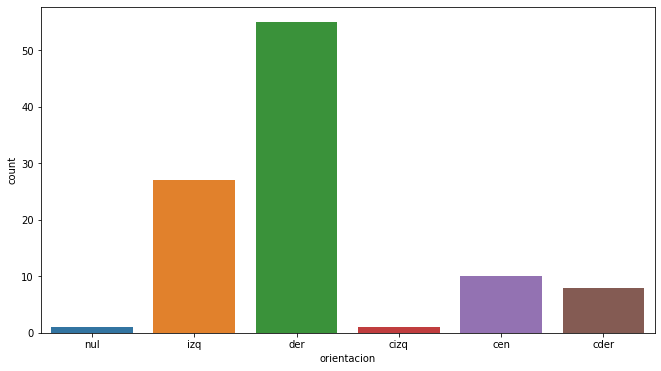

In [21]:
plt.figure(figsize=(11,6))
sns.countplot(politicosdb_df.orientacion)

## Mostramos el numero de politicos por partido

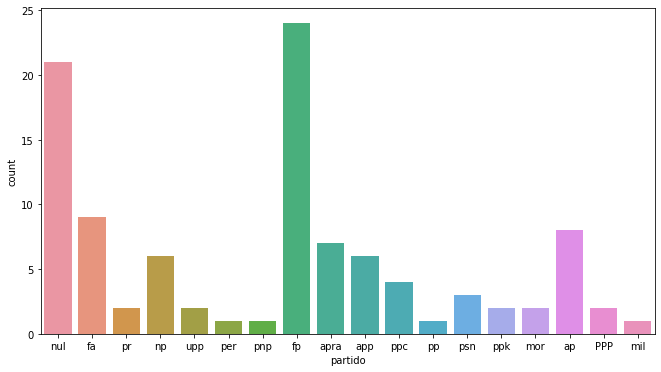

In [27]:
plt.figure(figsize=(11,6) )
sns.countplot(politicosdb_df.partido  )

### Mostramos el total de tweets por partido

#### **nul** significa que no tienen afiliacion a un partido (p.ej.periodistas, escritores), a pesar de eso pueden tener una preferencia política (**orientación**)

In [28]:
lst = []
for partido in conjunto_partidos:    
    df=partidosdf_dict[partido]
    nombre_partido = df.nombre_partido.iloc[0]
    _tweets = df['tweets'].sum()
    lst.append( (partido,_tweets,nombre_partido ) )
    
df1 = pd.DataFrame(lst, columns =['Partido', 'Tweets', 'Nombre partido'])
df1

,Partido,Tweets,Nombre partido
0,mor,4860,partido morado
1,ap,18990,accion popular
2,fp,135338,fuerza popular
3,ppk,5785,peruanos por el kambio
4,per,59,periodista
5,fa,62315,frente amplio
6,nul,238316,no conocido
7,pnp,12492,partido ollanta
8,mil,6390,militar
9,apra,26030,apra


#### **nul** significa que no tienen afiliacion a un partido (p.ej.periodistas, escritores), a pesar de eso pueden tener una preferencia política (**orientación**)

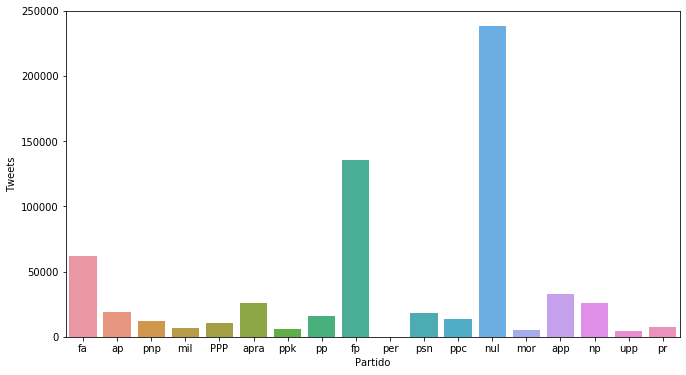

In [20]:
plt.figure(figsize=(11,6))
sns.barplot(x=df1.Partido, y=df1.Tweets)

### Mostramos total tweets según la orientacíon

In [21]:
lst = []
for orientacion in conjunto_orientacion:    
    df=orientaciondf_dict[orientacion]
    _tweets=df['tweets'].sum()
    lst.append( (orientacion,_tweets ) )
    
df2 = pd.DataFrame(lst, columns =['Orientacion', 'Tweets'])
print(f"TOTAL TWEETS RECUPERADOS: {df2.Tweets.sum()}")
df2

TOTAL TWEETS RECUPERADOS: 639259


,Orientacion,Tweets
0,der,334496
1,cen,49361
2,izq,219153
3,cizq,6513
4,nul,3227
5,cder,26509


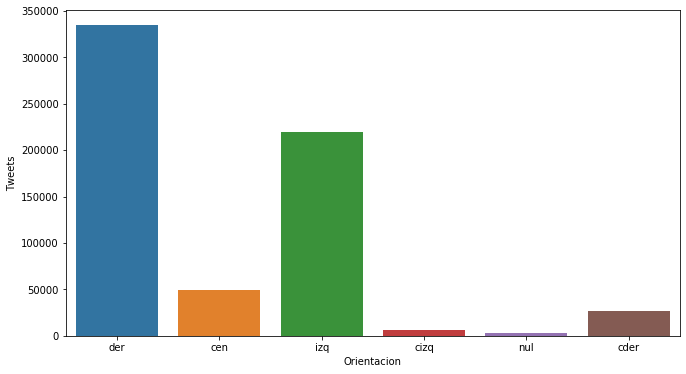

In [22]:
plt.figure(figsize=(11,6))
sns.barplot(x=df2.Orientacion, y=df2.Tweets)

### Creamos un Dataframe de tweets por cada partido político y lo guardamos como **f"tweets-partido-db_{partido}.csv"**.

In [23]:
# partidosdf_dict      : keys='partido'          items=DataFrame con la LISTA DE POLITICOS de ese partido
# politicosdf_dict     : keys='username' de un politico    items=DataFrame con tweets de ese politico

# partidounico_df_dict : keys='codigo de partido'         items=DataFrame con TODOS LOS TWEETS de ese partido
partidounico_df_dict = {}

for partido in conjunto_partidos:
    df_lista_partido=partidosdf_dict[partido]
    df_tmp = pd.DataFrame(columns=politicodf_list[0].columns)
    print(f"\nPartido: {partido}")
    print(f"Políticos: ",end="")
    for scr_name in df_lista_partido.screen_name:
        scr_name = scr_name[1:]
        print(f"{scr_name} / ",end="")
        df_polit = politicosdf_dict[ scr_name ]
        df_tmp=df_tmp.append(df_polit)
    partidounico_df_dict[ partido ] = df_tmp
    df_tmp.to_csv(f"tweets-partido-db_{partido}.csv", index=False)
print("Completo")


Partido: fa
Políticos: EnriqueFCHA / MarisaGlave / MirtyVas / Vero_Mendoza_F / vozdelatierra / HumbertoTYL / HCevallosFlores / rogelio_tucto / FrenteAmplioPe / 
Partido: ap
Políticos: JorgeMunozAP / VictorAndresGB / AccionPopular / MaricarmenAlvaP / ricardoburgaap / leslye_lazo / FabioTr_ / AleGarciaOviedo / 
Partido: pnp
Políticos: anajarav / 
Partido: mil
Políticos: OttoGuibovich / 
Partido: PPP
Políticos: NormaValverdeR1 / luissolarif / 
Partido: apra
Políticos: geluseg / JVelasquezQ / Mauriciomulder / APRAXXI / AlanGarciaPeru / evelinorcon / Valderrama_En / 
Partido: ppk
Políticos: fzavalal / gilbertvioleta / 
Partido: pp
Políticos: DanielUrresti1 / 
Partido: fp
Políticos: milytakayama / JVillaStein / MarthaChavezC / MIKI_Torres_ / ColumbusOpina / KarinaBeteta01 / chechechacon / RoloReategui / LuchoLopezVi / stapiab / LuzSalgado_R / UrsulaLetonaP / Pedro_Olaechea / hectorbecerrilr / luchogalarreta / albertofujimori / rosamariabartra / YeniVilcatoma2 / CalinDominguezH / GladysAndra

### Mostramos el DataFrame de un partido

In [24]:
partidounico_df_dict[ 'apra']

,id,User,Text,Date,Retweets,Mentions,HashTags,text_prep
0,1274402323180240898,geluseg,@TuKuyRiKuy4 Al escribidor MVLL no le liga una...,2020-6-20,1,@TuKuyRiKuy4,,escribidor mvll liga resultado obtuvo frente e...
1,1274349910054309888,geluseg,Vizcarra y el país del nunca jamás... Navegar ...,2020-6-20,4,,,vizcarra pais nunca jamas navegar desastre eco...
2,1274345486259040258,geluseg,"DE LOCOS... Inmovilizar para ""combatir"" al Cov...",2020-6-20,3,,,locos inmovilizar combatir covid bueno tras ag...
3,1274342668416540672,geluseg,@CristhianRS Y de paso ¿porque no nos tiramos ...,2020-6-20,0,@CristhianRS,,paso tiramos solo golpe varias estatuas caminan
4,1274341738346315776,geluseg,@VanyaThais @PersiCristal400 ¡Pero claro! Tamb...,2020-6-20,1,@VanyaThais @PersiCristal400,,claro tambien aquel gobierno compro chatarra c...
...,...,...,...,...,...,...,...,...
4749,432905662956204032,Valderrama_En,El gobierno del clan Humala premia su incapaci...,2014-02-10,0,,#ABajoElAumentoHumala,gobierno clan humala premia incapacidad clamor...
4750,430587263060176897,Valderrama_En,"@cynthiavallesl Porque ti amo, en italiano dad...",2014-02-04,0,@cynthiavallesl,,italiano dado contexto familiar jajaja
4751,430586499428397057,Valderrama_En,A pesar de todo un gran inicio de semana. Lo m...,2014-02-04,0,@cynthiavallesl,,pesar gran inicio semana mejor
4752,426028924737298432,Valderrama_En,@canalN_ Que sería un extraordinario gobierno ...,2014-01-22,0,@canalN_,,seria extraordinario gobierno mejor podria pas...


### Creamos un Dataframe de tweets por cada orientación politica y lo guardamos como **f"tweets-orientacion-db_{orientacion}.csv"**.

In [25]:
# partidosdf_dict      : keys='partido'                  items=DataFrame con la LISTA DE POLITICOS de ese partido
# orientaciondf_dict   : keys='orientacion'              items=DataFrame con la LISTA de POLITICOS de esa orientacion
# politicosdf_dict     : keys='username' de un politico  items=DataFrame con tweets de ese politico

# orientacion_df_dict  : keys='orientacion               items=DataFrame con TODOS LOS TWEETS de esa orientacion
orientacionunico_df_dict = {}

for orientacion in conjunto_orientacion: 
    df_lista_orient=orientaciondf_dict[orientacion]
    df_tmp = pd.DataFrame(columns=politicodf_list[0].columns)
    print(f"\nOrientacion: {orientacion}")
    print(f"Políticos: ",end="")
    for scr_name in df_lista_orient.screen_name:
        scr_name = scr_name[1:]
        print(f"{scr_name} / ",end="")
        df_polit = politicosdf_dict[ scr_name ]
        df_tmp=df_tmp.append(df_polit)
    orientacionunico_df_dict[ orientacion ] = df_tmp
    df_tmp.to_csv(f"tweets-orientacion-db_{orientacion}.csv", index=False)
print("\nCompleto")


Orientacion: der
Políticos: LucianoRevoredo / milytakayama / geluseg / amariateguinof / LuisValdezF / olopezm67 / JBedoyaDenegri / JVelasquezQ / Mauriciomulder / JVillaStein / MarthaChavezC / DanielUrresti1 / martinbelaundem / rlopezaliaga1 / APRAXXI / MIKI_Torres_ / FioreMolinelli / eddelaguila / melissapradell / ColumbusOpina / KarinaBeteta01 / JuanSheput / chechechacon / RoloReategui / nemo17molle / SalvadorHeresi / fzavalal / OmarChehadeMoya / AlcortaLourdes / LuchoLopezVi / aaronsalomong / LourdesFloresN / reyreysincorona / JBCPERU / AlanGarciaPeru / stapiab / LuzSalgado_R / UrsulaLetonaP / Pedro_Olaechea / hectorbecerrilr / evelinorcon / luchogalarreta / albertofujimori / rosamariabartra / YeniVilcatoma2 / CalinDominguezH / gilbertvioleta / GladysAndradeSA / dsalaverryv / RoyVenturaA / LizbethRoblesU / jorgevillenal / marpereztello / Valderrama_En / A_Aguinaga / 
Orientacion: cen
Políticos: AlbertoBelaunde / JorgeMunozAP / hugonopo / NormaValverdeR1 / luis_albertoqv / OttoGuibov

### Mostramos el DataFrame de una orientacion

In [37]:
#Mostramos centro-derecha : cder
orientacionunico_df_dict[ 'der' ].reset_index()

,index,id,User,Text,Date,Retweets,Mentions,HashTags,text_prep
0,0,1276508765576220672,LucianoRevoredo,RT @ugluis: Alocución del Almirante Jorge Mont...,2020-6-26,16,@ugluis,,alocucion almirante jorge montoya pocos lidere...
1,1,1276508727886196737,LucianoRevoredo,RT @alvarosarco: El cobarde de Vizcarra queján...,2020-6-26,96,@alvarosarco,,cobarde vizcarra quejandose exigen resolver pr...
2,2,1276508661209333762,LucianoRevoredo,RT @giulianacaccia: ¿Quiénes son “nos”? ¿El p...,2020-6-26,5,@giulianacaccia,,pueblo decia mismo habia escucharlo cerraba co...
3,3,1276508585959272448,LucianoRevoredo,RT @gabriellaperu: Cómo podría quejarse el gob...,2020-6-26,3,@gabriellaperu @ActualidadRT,,podria quejarse gobierno totalitarios destruya...
4,4,1276508335588638721,LucianoRevoredo,RT @giulianacaccia: Una especie de sexto senti...,2020-6-26,10,@giulianacaccia,,especie sexto estilo ágatha dice paridad alter...
...,...,...,...,...,...,...,...,...,...
334491,5322,273810898626424832,A_Aguinaga,http://elcomercio.pe/actualidad/1502455/notici...,2012-11-28,0,,,
334492,5323,273810846608674817,A_Aguinaga,http://elcomercio.pe/actualidad/1502455/notici...,2012-11-28,0,,,
334493,5324,272931176602271745,A_Aguinaga,@antoniomanco preocupante realidad que enfrent...,2012-11-26,0,@antoniomanco,,preocupante realidad enfrentan ffaa
334494,5325,270647957102149633,A_Aguinaga,@KenjiFujimoriH VLL no supera su trauma d la d...,2012-11-19,0,@KenjiFujimoriH,,supera trauma derrota fujimori confunde realid...


---
## El trabajo continua en el notebook   **TA_POLITICA-04_analisis_explorativo.ipynb**
